In [1]:
################################################################################
##############    Classification: Multi-Layer Perceptron    ##############
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import math

import neuralsens as ns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as mtrs
# Multicolor line
import matplotlib.collections 

from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import preprocessing
import math
import ClassificationTools as CT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [2]:
### Load file --------------------------------------------
df = pd.read_csv('Simdata.dat', sep = "\t")
df.head()

,X1,X2,Y
0,-3.745291,3.729409,NO
1,5.806532,-4.703332,YES
2,4.209833,-0.493488,YES
3,3.429156,-2.307669,NO
4,-0.195014,2.680303,NO


In [3]:
### Convert output variable to factor
df.Y = df.Y.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      1000 non-null   float64 
 1   X2      1000 non-null   float64 
 2   Y       1000 non-null   category
dtypes: category(1), float64(2)
memory usage: 16.8 KB


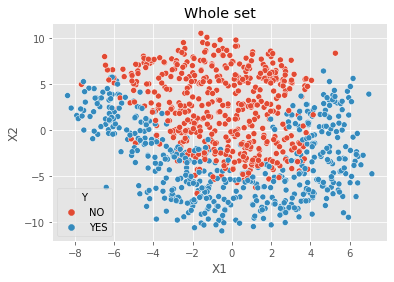

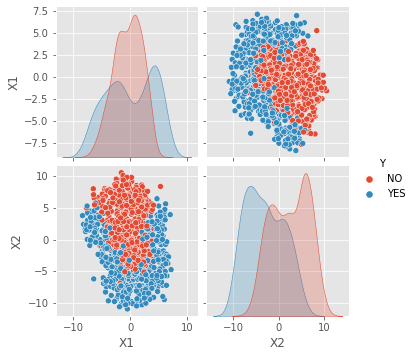

In [4]:
### Exploratory analysis -------------------------------------------------------------------------------------
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = df).set_title("Whole set")
plt.show()
sns.pairplot(df, hue = 'Y')
plt.show()

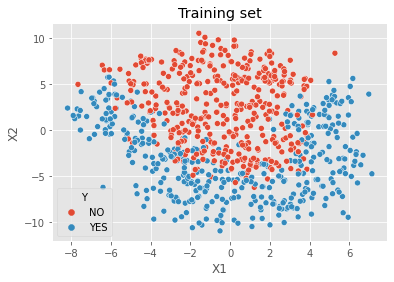

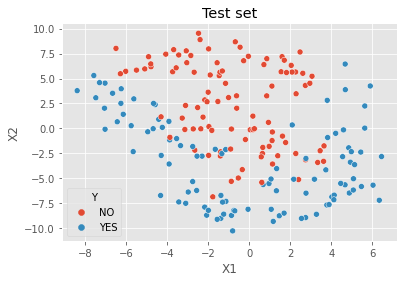

In [5]:
X = df[['X1','X2']]
y = df['Y']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

## plot training and test sets. 
## Try changing the value inside set.seed(). How does it affect the selected data?
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTR_eval).set_title("Training set")
plt.show()
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTS_eval).set_title("Test set")
plt.show()



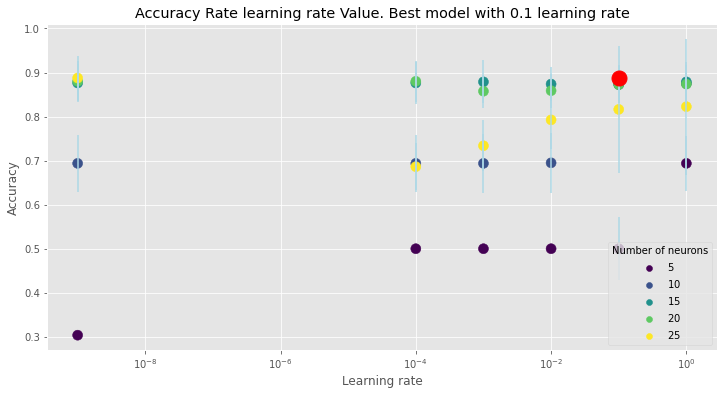

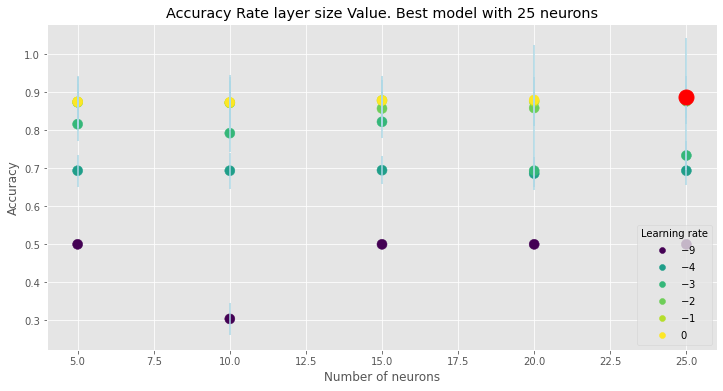

In [6]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
param = {'MLP__learning_rate_init': [1e-9,0.0001,0.001,0.01,0.1,1], # Initial value of learning rate 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='adam', # Update function
                                             activation='logistic', # Logistic sigmoid activation function
                                             alpha=0.01, # L2 regularization term
                                             learning_rate='adaptive', # Type of learning rate used in training
                                             max_iter=250, # Maximum number of iterations
                                             batch_size=10, # Size of batch when training
                                             tol=1e-4, # Tolerance for the optimization
                                             validation_fraction=0.0, # Percentage of samples used for validation
                                             n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                             random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train, y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(MLP_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = MLP_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_MLP = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.errorbar(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
             [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
            [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
            c=[a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Number of neurons")
plt.plot(MLP_fit.best_params_['MLP__learning_rate_init'], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate learning rate Value. Best model with ' + str(MLP_fit.best_params_['MLP__learning_rate_init']) + ' learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
             [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
             yerr=[x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
            [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
            c=np.log10(np.array([a for a in MLP_fit.cv_results_['param_MLP__learning_rate_init']],dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Learning rate")
plt.plot(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate layer size Value. Best model with ' + str(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0]) + ' neurons')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.show()


In [7]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['scaler'].transform(X_train)
X = pd.DataFrame(X, columns=X_train.columns)
y = y_train
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [8]:
    
sensmlp = ns.SensAnalysisMLP(wts, bias, actfunc, X, y)

In [9]:
sensmlp.summary()

Sensitivity analysis of [2, 25, 1] MLP network.

Sensitivity measures of each output:

$Y 

        mean       std  mean_squared
X1 -0.002602  0.553157       0.30599
X2 -0.280919  0.284929       0.16010


In [10]:
sensmlp.info()

Sensitivity analysis of [2, 25, 1] MLP network.

800 samples

Sensitivities of each output (only 5 first samples):

$Y 

         X1        X2
0  0.225388 -0.081809
1  0.003290 -0.001858
2  0.782654 -0.585043
3  0.392727 -0.125354
4 -1.172081 -0.811659


c:\Users\jaime\OneDrive - Universidad Pontificia Comillas\MBD_2021\Python_ML\P2_4_MLP\neuralsens.py:214: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  colors = plt.cm.cmap_d['Blues_r'](sens['mean_squared']*0.5/max(sens['mean_squared']))


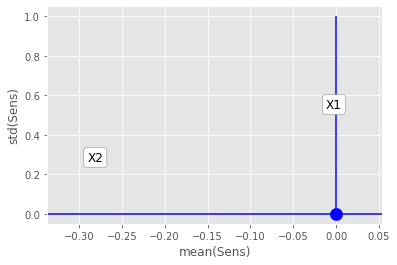

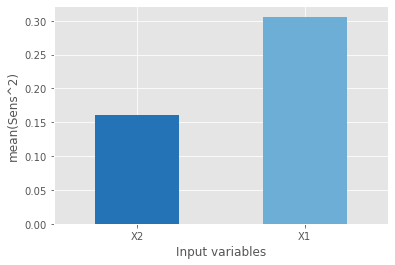

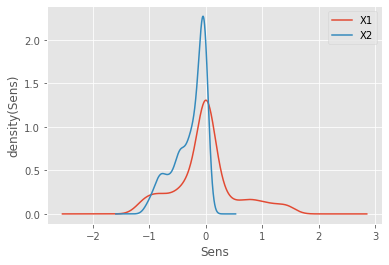

In [11]:
sensmlp.plot()

In [18]:
import dill                            
filepath = 'session.pkl'
dill.dump_session(filepath) # Save the session

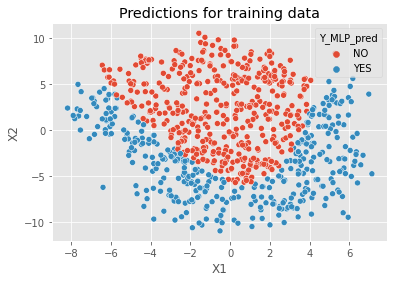

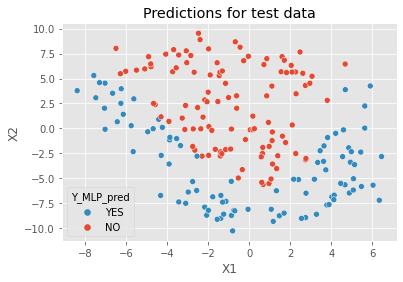

In [12]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train)
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test)
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_MLP_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_MLP_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()


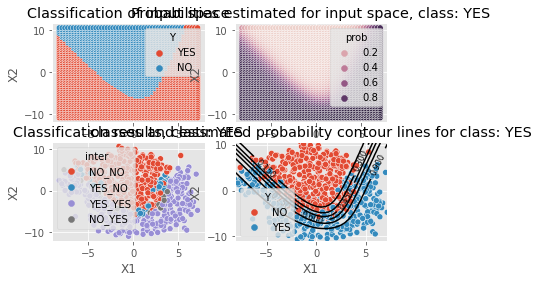

In [13]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], MLP_fit, 'X1', 'X2', 'YES', 50) 

In [14]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_MLP_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 368   32
      YES  68  332

Accuracy: 0.88
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.83
Specificity: 0.92
Pos pred value: 0.91
Neg pred value: 0.84
Prevalence: 0.5
Detection Rate: 0.42
Detection prevalence: 0.46
Balanced accuracy: 0.88
F Score: 0.87
Positive class: YES


In [15]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_MLP_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   84  16
       NO    9  91

Accuracy: 0.88
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.23
Sensitivity: 0.91
Specificity: 0.84
Pos pred value: 0.85
Neg pred value: 0.9
Prevalence: 0.5
Detection Rate: 0.46
Detection prevalence: 0.54
Balanced accuracy: 0.88
F Score: 0.88
Positive class: NO


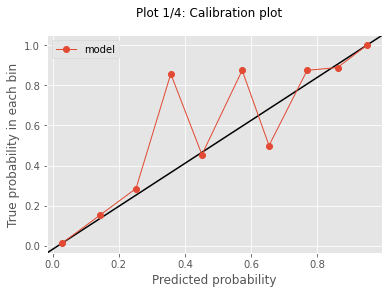

No handles with labels found to put in legend.


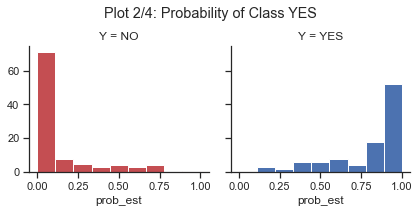

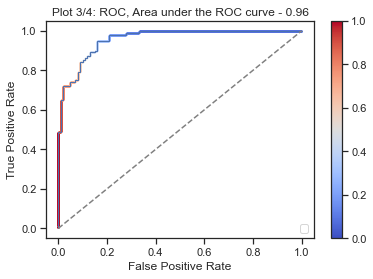

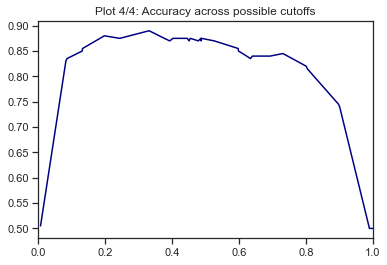

In [16]:
CT.plotClassPerformance(dfTS_eval['Y'], MLP_fit.predict_proba(X_test)[:,1], selClass='YES')